# **Predicting CO² Emission by Vehicles**
## **Classification - Machine Learning**

<!DOCTYPE html>
<html>
<head>
<style>
  .centered-image {
    display: block;
    margin: 0 auto;
    max-width: 30%; /* Hier können Sie die maximale Breite einstellen */
    height: auto;    /* Das Verhältnis wird beibehalten */
  }
</style>
</head>
<body>
  <a href=>
    <img class="centered-image" src="https://static.vecteezy.com/system/resources/previews/005/893/697/non_2x/car-emits-co2-gas-pollution-of-carbon-dioxide-from-traffic-co2-cloud-gas-icon-traffic-pollution-from-vehicle-icon-illustration-vector.jpg" alt="Co2_cars">
  </a>
</body>
</html>



## **Load data**
### **Import libraries**

In [45]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error, r2_score
from tqdm.notebook import *
from sklearn.preprocessing import OneHotEncoder # for one-hot encoding
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, accuracy_score, confusion_matrix, f1_score
import joblib
from sklearn.model_selection import cross_validate
import os
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, cross_validate
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline



### **Load data**

In [ ]:
# script was initally used locally, so the data path may be different
#df = pd.read_csv(r"C:\Datasets\CO2_Emissions\data_2021_CO2_Project_Fr_preprocessed.csv")

df = pd.read_csv("../data/data_2021_CO2_Project_Fr_preprocessed.csv")

### **Preprocessing ML**

In [46]:
# Create a target variable 'target' by binning the values in 'Ewltp_g/km'
target = pd.cut(x=df['Ewltp_g/km'], bins=[0, 100, 120, 140, 160, 200, 250, np.inf], labels=['1', '2', '3', '4', '5', '6', '7'], right=True)

# Drop the column 'Ewltp_g/km' from the DataFrame
data = df.drop('Ewltp_g/km', axis=1)

In [48]:
# Drop the columns 'Cr', 'IT', 'Fc', and 'Er_km' from the DataFrame
data = data.drop(['Cr', 'IT', 'Fc', 'Er_km'], axis=1)

### **Oversampling**

To tackle the issue of imbalanced class distribution within the dataset, oversampling techniques were employed. Specifically, the 'RandomOverSampler' from the 'imbalanced-learn' library was utilized. This process involves generating synthetic samples for the minority classes, thereby balancing the class distribution and preventing the model from being biased towards the majority class.
Before the application of oversampling, the dataset exhibited a certain distribution among its classes. Post-oversampling, the dataset underwent a transformation to ensure a more equitable representation of classes, contributing to a more balanced and fair training process. This strategic preprocessing step is essential for improving the model's capacity to recognize patterns and make accurate predictions across all classes, ultimately enhancing the Random Forest Classifier's robustness and reliability.


In [49]:
# Display the shape of the data before over-sampling
print(f'Data shape before over-sampling {data.shape}')

# Create a RandomOverSampler instance
ros = RandomOverSampler()

# Apply over-sampling to the data and target variables
data_ros, target_ros = ros.fit_resample(data, target)

# Display the shape of the data after over-sampling
print(f'Data shape after over-sampling {data_ros.shape}')

Data shape before over-sampling (1589748, 26)
Data shape after over-sampling (4808811, 26)


## **Functions**

### **Split and Scale Data**

In [50]:
# Function to Split and Scale the Data

def split_scale(X, y, test_size=0.3, scaler_to_apply=StandardScaler):
    """
    Split the data into training and testing sets, and scale the features.

    Parameters:
    - X: Features data
    - y: Target variable data
    - test_size: Proportion of the data to include in the test split (default is 0.3)
    - scaler_to_apply: Scaler to be applied (default is StandardScaler)

    Returns:
    - X_train_scaled: Scaled features for the training set
    - X_test_scaled: Scaled features for the testing set
    - y_train: Target variable for the training set
    - y_test: Target variable for the testing set
    """

    # Split the data into training and testing sets, maintaining the stratification of the target variable
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y)

    # Initialize the scaler
    scaler = scaler_to_apply()

    # Fit the scaler on the training data and transform both training and testing sets
    scaler.fit(X_train, y_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Return the scaled data along with the target variables
    return X_train_scaled, X_test_scaled, y_train, y_test


# Apply the split_scale function to the data and target variables using StandardScaler
X_train, X_test, y_train, y_test = split_scale(data_ros, target_ros, scaler_to_apply=StandardScaler)


### **Feature importance**

In [56]:

def display_feature_importance(data, feature_names, clf, top_n=10):
    '''
    Display a horizontal bar plot of the top N feature importances
    clf : fitted classifier with results including feature_importances_
    data : data including feature names
    feature_names : list of feature names
    top_n : number of top features to display (default is 10)
    Returns:
      - Bar plot
      - Feature importance as data Frame {'Feature': , 'Importance':}
      - Top N feature importances as a list
    '''

    feature_importance = clf.feature_importances_
    indices = feature_importance.argsort()[::-1][:top_n] 
    sorted_feature_names = [feature_names[i] for i in indices]
    top_n_feature_importances = feature_importance[indices]

    # Create a DataFrame to display feature importance
    feature_importance_df = pd.DataFrame({'Feature': sorted_feature_names, 'Importance': top_n_feature_importances})

    # Print top N feature importances
    print(f'Top {top_n} Feature Importances:')
    for feature, importance in zip(sorted_feature_names, top_n_feature_importances):
        print(f'{feature}: {importance:.4f}')

    # Plot the feature importance using sns.barplot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')

    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'', loc="left", fontweight="bold", pad=20)
    plt.show()
    
    return feature_importance_df, list(zip(sorted_feature_names, top_n_feature_importances))


### **Results**

In [54]:
# Function to Evaluate Classifier Performance and Provide Insights

def classifier_results(X_train, y_train, X_test, y_test, feature_names, clf_name, n_folds=5,  **params):
    """
    Evaluate the performance of a classifier, display various metrics, and save the trained model.

    Parameters:
    - X_train: Features data for the training set
    - y_train: Target variable data for the training set
    - X_test: Features data for the testing set
    - y_test: Target variable data for the testing set
    - feature_names: Names of the features
    - clf_name: Classifier class to be used
    - n_folds: Number of folds for cross-validation (default is 5)
    - **params: Additional parameters for the classifier

    Returns:
    - Dictionary containing various outputs and metrics
    """

    # Initiate a classifier from the provided classifier class
    clf = clf_name(**params)

    # Fit the classifier on the training set
    clf.fit(X_train, y_train)

    # Print the accuracy score based on the test set
    print(f'({clf_name} score = {format(clf.score(X_test, y_test), ".2f")})')

    # Run cross-validation and print scores for each scoring metric used
    cv_kf = KFold(n_splits=n_folds, shuffle=True)
    scoring_metrics = ['roc_auc_ovr', 'f1_macro']
    clf_scores = cross_validate(clf, X_train, y_train, cv=cv_kf, scoring=scoring_metrics, return_train_score=False)
    for metric in scoring_metrics:
        mean_score = clf_scores[f'test_{metric}'].mean()
        print(f"Mean {metric}:", mean_score)

    # Display feature importance Bar plot
    feature_importance = display_feature_importance(X_train, feature_names, clf)

    # Predict the target for the test set
    y_pred = clf.predict(X_test)

    # Display confusion matrix
    conf_mat = pd.DataFrame(pd.crosstab(y_test, y_pred, rownames=['True Values'], colnames=['Predictions']))
    print(conf_mat)

    # Display classification report
    classif_report = classification_report(y_test, y_pred)
    print(classif_report)

    # Save the trained classifier using joblib with a dynamically generated filename and full path
    #folder_path = r'C:\Datasets\CO2_Emissions\Streamlit'
    #filename = os.path.join(folder_path, f'{clf_name.__name__}_trained_classifier.joblib')
    #joblib.dump(clf, filename)

    # Create a dictionary with various outputs and metrics
    output = {
        'clf_': clf,
        'clf_scores_': clf_scores,
        'feature_importance_': feature_importance,
        'predictions_': y_pred,
        'conf_mat_': conf_mat,
        'classif_report_': classif_report,
     #   'filename': filename
    }

    return output


## **Classification models**

### **Selecting a Classification Model**
Choosing an appropriate classification model is crucial for the success of a Machine Learning project. In our case, after careful evaluation of requirements and data context, we opted for the Random Forest, Decision Tree, and XGBoost models. The selection is based on various aspects:
1. **Random Forest:**
- Ensemble Technique: Random Forest is an ensemble technique based on multiple Decision Trees. Combining multiple models enhances robustness and reduces overfitting.
- High Precision: Aggregating predictions from many Decision Trees often results in higher precision and robustness against outliers compared to individual Decision Trees.
- Handling Feature Diversity: Random Forest can effectively handle datasets with a variety of features and provides automatic feature importance evaluations.


2. **Decision Tree:**
- Simple Interpretation: Decision trees are easily understandable and interpretable. This is crucial for gaining insights into the model's decision-making and explaining results to stakeholders.
- Natural Decision Structure: Decision Trees model decisions in an intuitive tree structure, often resembling human-like reasoning.
3. **XGBoost (Extreme Gradient Boosting):**
- Gradient Boosting Technique: XGBoost is a powerful implementation of the gradient boosting technique, allowing gradual improvement of model performance by combining multiple weak models.
- High Precision and Speed: XGBoost offers high precision with fast processing, making it a popular choice in competitions and demanding projects.
- Overfitting Regulation: Implementation of regularization techniques in XGBoost helps prevent overfitting and stabilizes model performance.
4. **Overall Selection Justification:**
- Ensemble Advantages: By integrating Random Forest and XGBoost, we harness the advantages of ensemble methods to achieve robust, precise, and generalizable classification.
- Interpretability and Simplicity: The inclusion of a Decision Tree allows for straightforward interpretation and explanation of model decisions, particularly crucial when the model influences political or business decisions.
- Consideration of Data Complexity: The model selection considers the potential complexity of the data, ranging from simpler Decision Trees to powerful ensemble techniques.

Overall, this selection provides a balanced trade-off between precision, interpretability, and robustness. The models were evaluated and fine-tuned on a validation dataset to ensure good generalization and avoid overfitting before assessing their final performance on the test dataset.


### **Basic Random Forest**
#### **Implemenation**

In the implementation of the Machine Learning model, we employed the 'scikit-learn' library, a versatile and widely-used toolkit for various data analysis and modeling tasks. The primary focus was on utilizing the Random Forest Classifier, a powerful Ensemble Learning method. The 'RandomForestClassifier' class within scikit-learn provided the foundation for constructing the ensemble model, which is essentially a collection of Decision Trees.

The dataset was divided into training and testing sets with a testing size of 0.3, represented by X_train, y_train, X_test, and y_test. To better understand the features used in the analysis, we referenced data_ros.columns to obtain the column names. This step is crucial for maintaining clarity and coherence throughout the analysis.

During the training phase, the 'RandomForestClassifier' was configured with specific parameters to enhance model performance and efficiency. Cross-validation, a robust technique for assessing model generalization, was employed with n_folds set to 5. This parameter determines the number of folds in the cross-validation process, contributing to a thorough evaluation of the model's predictive capabilities.

Additionally, the ‘n_jobs’ parameter was set to -1, indicating parallelization across all available processor cores. This optimization significantly accelerated the training process, making it more efficient and scalable.
The resulting Random Forest model was then evaluated using the testing set, providing valuable insights into its performance metrics, such as accuracy, precision, recall, and F1-score. Moreover, the feature importance analysis was conducted to identify the significance of each feature in contributing to the model's predictions.


(<class 'sklearn.ensemble._forest.RandomForestClassifier'> score = 0.97)
Mean roc_auc_ovr: 0.9992732687580318
Mean f1_macro: 0.9710974576683172
Top 10 Feature Importances:
ep_KW: 0.1909
m_kg: 0.1760
At1_mm: 0.1234
ec_cm3: 0.1116
W_mm: 0.0838
z_Wh/km: 0.0417
Erwltp_g/km: 0.0394
Fm_P: 0.0356
Ft_HYBRID: 0.0351
Ft_PETROL: 0.0239


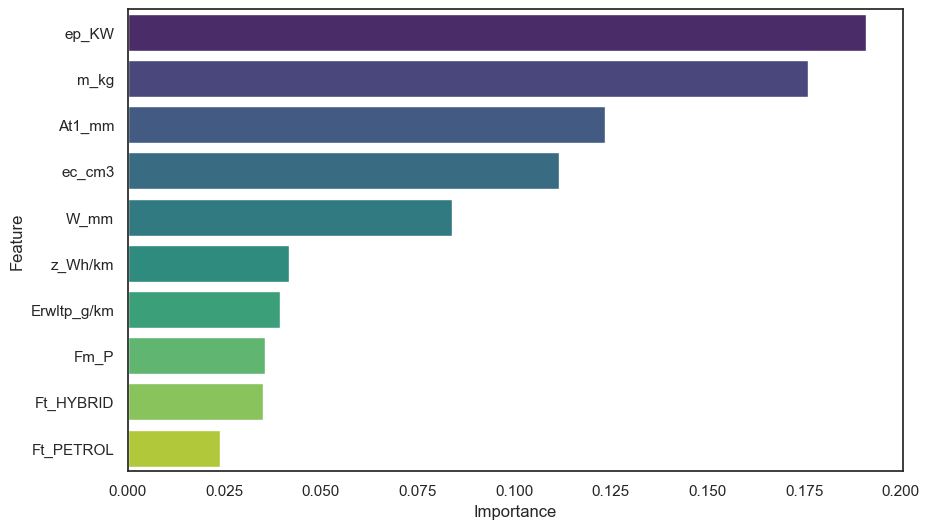

Predictions       1       2       3       4       5       6       7
True Values                                                        
1            144256       8       0       0       0       0       0
2               109  140701    3454       0       0       0       0
3                 0    6198  132904    5163       0       0       0
4                 2       0    3112  135900    5251       0       0
5                 0       0       0    2955  140778     532       0
6                 0       0       0       0      86  142894    1284
7                 0       0       0       0       0    1027  143237
              precision    recall  f1-score   support

           1       1.00      1.00      1.00    144264
           2       0.96      0.98      0.97    144264
           3       0.95      0.92      0.94    144265
           4       0.94      0.94      0.94    144265
           5       0.96      0.98      0.97    144265
           6       0.99      0.99      0.99    144264
         

In [57]:
# Run random forest classifier on ros data
rf_basic_ros = classifier_results(X_train, y_train, X_test, y_test, data_ros.columns,
                                   RandomForestClassifier,
                                   n_folds=5,
                                   **{'n_jobs': -1})

#### **Evaluation:  Basic Random Forest**

- The Random Forest Classifier showcased exceptional performance across various metrics, affirming its suitability for the vehicle classification task. With an impressive overall accuracy of 97%, the model demonstrated a high level of correctness in predicting vehicle types within the test dataset.
- A notable strength of the Random Forest model is evident in the ‘mean roc_auc_ovr value’ of 0.9993, emphasizing its outstanding ability to discriminate between different vehicle classes. This metric is particularly crucial in multi-class classification scenarios, and the model's near-perfect score reflects its robust discriminatory power.
- The ‘mean f1_macro score’, standing at 0.9712, further underscores the model's proficiency. This metric provides a balanced assessment of precision and recall across all classes, indicating that the Random Forest Classifier maintains a harmonious trade-off between accurately identifying positive instances and avoiding false positives.
- Precision, a key metric, measures the model's ability to correctly classify positive instances among the predicted positive labels. In the context of the Random Forest Classifier, high precision values across different vehicle classes highlight the model's accuracy in avoiding false positives and making precise predictions for each category.
- The confusion matrix provides a detailed breakdown of the model's predictions, illustrating correct and erroneous classifications for each class. Notably, the diagonal elements, representing correct predictions, dominate the matrix, confirming the model's overall accuracy.
- Analyzing class-specific metrics, including precision, recall, and F1-Score, offers insights into the model's performance for individual classes. High precision values indicate the model's proficiency in minimizing false positives and making precise predictions for each vehicle type.

#### **Feature Importance**

- Engine power (‘ep_KW’) and vehicle weight (‘m_kg’) emerge as the most influential features, contributing 19.09% and 17.60%, respectively, to the decision-making process of the Random Forest model. The dimensional attribute At1_mm and engine capacity (‘ec_cm3’) also play crucial roles, representing 12.34% and 11.16% importance, respectively.
- Furthermore, features such as ‘W_mm’, ‘z_Wh/km’, ‘Erwltp_g/km’, and fuel-related attributes like ‘Fm_P’, ‘Ft_HYBRID’, and ‘Ft_PETROL’, contribute significantly to the model's accuracy. The feature importance values range from 8.38% to 2.39%, indicating the varying degrees of influence each attribute has on the model's predictions.





### **Basic DecisionTree**

#### **Implementation**

In our analysis, we implemented the Decision Tree Classifier using the 'scikit-learn' library in Python. The Decision Tree model stands out as a powerful tool for classification tasks due to its interpretability and versatility. The following outlines how we configured, trained, and evaluated the Decision Tree model. We initiated the Decision Tree classifier using the DecisionTreeClassifier class from scikit-learn, a widely used Machine Learning library. The dataset was divided into training and testing sets using the 'train_test_split' function to ensure the model's generalization to unseen data. To robustly assess the model's performance, we employed K-Fold Cross-Validation with 5 folds. This approach provides a more reliable estimate of the model's capabilities by training and testing on different subsets of the data. For model evaluation, we chose essential scoring metrics, including 'roc_auc_ovr' (area under the ROC curve) and 'f1_macro' (F1-Score). These metrics offer insights into the model's ability to discriminate between classes and its overall performance. To better understand the features contributing to the model's decisions, we visualized the feature importance using a bar plot. This step aids in identifying the most influential variables in the classification process. Finally, we made predictions on the test set and presented the results through a confusion matrix and a classification report. These provide a detailed breakdown of predictions for each class, including precision, recall, and F1-Score.




(<class 'sklearn.tree._classes.DecisionTreeClassifier'> score = 0.97)
Mean roc_auc_ovr: 0.9992657535084067
Mean f1_macro: 0.9711316137321315
Top 10 Feature Importances:
ep_KW: 0.3022
m_kg: 0.2573
Ft_HYBRID: 0.1166
At1_mm: 0.0726
ec_cm3: 0.0497
Fm_H: 0.0430
W_mm: 0.0419
Erwltp_g/km: 0.0282
Ft_OTHER: 0.0180
Ft_PETROL: 0.0141


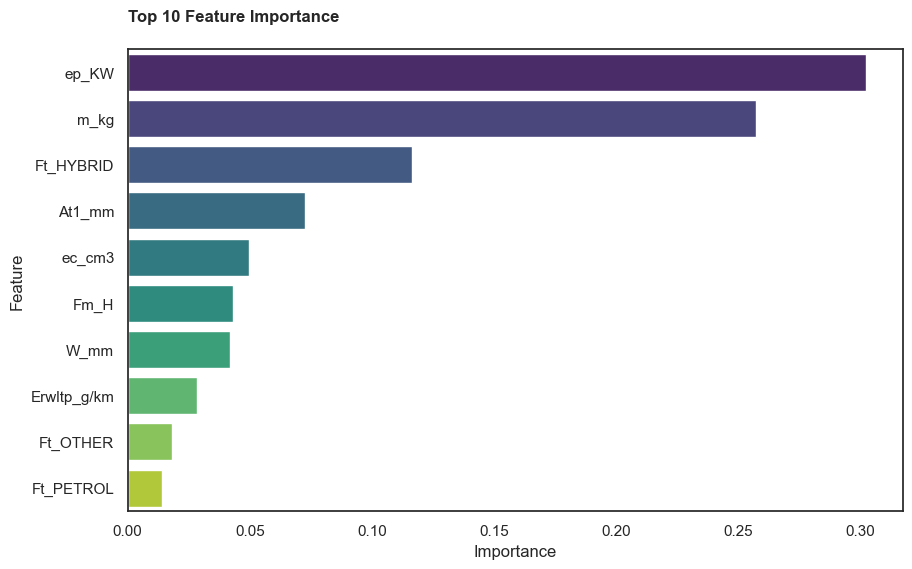

Predictions       1       2       3       4       5       6       7
True Values                                                        
1            206082      10       0       0       0       0       0
2               145  200830    5117       0       0       0       0
3                 0    8678  190290    7124       0       0       0
4                 4       0    4515  197016    4556       1       0
5                 0       0       0    7217  198112     763       0
6                 0       0       0       0     145  203904    2043
7                 0       0       0       0       0    1163  204929
              precision    recall  f1-score   support

           1       1.00      1.00      1.00    206092
           2       0.96      0.97      0.97    206092
           3       0.95      0.92      0.94    206092
           4       0.93      0.96      0.94    206092
           5       0.98      0.96      0.97    206092
           6       0.99      0.99      0.99    206092
         

In [269]:
# Create a Decision Tree Classifier instance with default parameters
dt_basic = classifier_results(X_train, y_train, X_test, y_test, data_ros.columns,
                                          DecisionTreeClassifier,
                                          n_folds=5,
                                          **{})

#### **Evaluation: Basic DecisionTree**

- The Decision Tree model has demonstrated exceptional efficacy in predicting vehicle categories within the test set, achieving an impressive accuracy of 97%. This accuracy reflects the model's ability to make correct predictions across the seven distinct classes, showcasing its proficiency in handling complex classification tasks.
- Robust Discrimination Capability: The model's discriminative power is highlighted by its exceptional mean roc_auc_ovr score of 0.9993. This score signifies the model's robustness in distinguishing between the different vehicle categories, showcasing its capability to effectively capture the underlying patterns in the data.
- Precision-Recall Balance: The mean f1_macro score, standing at 0.9711, indicates a harmonious balance between precision and recall across all classes. This equilibrium is crucial in classification tasks, ensuring that the model maintains accuracy while considering both false positives and false negatives. The model's ability to strike this balance is a testament to its adaptability in capturing the complexities of the dataset.
- Confusion Matrix Insights: The confusion matrix provides a detailed breakdown of the model's predictions for each class, offering valuable insights into various performance metrics.
- Precision (0.93 to 1): Precision scores ranging from 0.93 to 1 demonstrate the model's precision in correctly identifying instances for each class. A high precision score implies a low rate of false positives, indicating the model's accuracy in labeling instances.
- Recall (0.92 to 1): Recall values between 0.92 and 1 reflect the model's effectiveness in capturing a significant portion of positive instances for each class. A high recall emphasizes the model's ability to detect relevant patterns within the data.
- F1-Score (0.94 to 1): F1-Scores, harmonizing precision and recall, range from 0.94 to 1, underscoring the model's overall accuracy. The F1-Score considers both false positives and false negatives, providing a comprehensive assessment of the model's performance.

In conclusion, the Decision Tree model exhibits a robust classification performance, excelling in accuracy, discrimination capability, and the delicate balance between precision and recall across diverse vehicle classes. These findings establish the Decision Tree model as a compelling choice for this classification task, laying the groundwork for further model comparisons and in-depth analysis.

#### **Feature Importance**


- The bar plot illustrates the top 10 feature importances derived from our Decision Tree classification model. The analysis underscores the pivotal role of certain features in predicting CO² emissions from vehicles. Notably, engine power (‘ep_KW’) and vehicle weight (‘m_kg’) emerge as the most influential factors, contributing 30.22% and 25.73%, respectively, to the model's decision-making process.The presence of hybrid fuel type (‘Ft_HYBRID’) also plays a significant role, representing 11.66% importance in the model's predictions.
- In addition, the dimensional features, ‘At1’_mm and ‘W_mm’, as well as engine-related attributes like fuel metering system (‘Fm_H’) and engine capacity (‘ec_cm3’), are identified as essential contributors to the model's robust performance. The feature importance values, ranging from 4.41% to 0.37%, emphasize the varying degrees of influence each attribute exerts on the model's predictions.


#### **Optimization DecisionTree**

The hyperparameter tuning process for the Decision Tree model involved a meticulous exploration of key parameters to enhance the model's predictive performance. Here's a detailed breakdown of the hyperparameters and their respective settings:
1.	**‘criterion’:**
- The criterion parameter defines the quality measurement function for the split.
- Options considered: 'gini', 'entropy', and 'log_loss'.
1.	**‘max_depth’:**
- Specifies the maximum depth of the Decision Tree.
- Tested values: 5, 10, 25, 50, 100.

The tuning process also followed a systematic Grid Search approach, where various combinations of these hyperparameters were evaluated using KFold cross-validation with 3 folds and random shuffling. This ensured a robust assessment of model performance across different data splits, helping identify the optimal configuration.
The chosen values for criterion aimed to assess different split criteria, such as Gini impurity, information gain (‘entropy’), and ‘log loss’. For ‘max_depth’, the exploration focused on varying tree depths to strike a balance between capturing complex patterns and preventing overfitting.
The Grid Search methodology allowed for an exhaustive search through the hyperparameter space, aiming to maximize the model's effectiveness. This methodical approach aligns with our commitment to precision and efficiency in model development, tailored to the specific requirements of our dataset.


In [270]:
# Create a Decision Tree Classifier instance
dt_opt = DecisionTreeClassifier()

# Define a dictionary of hyperparameters to be optimized
params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [5, 10, 25, 50, 100]
}

# Create a KFold cross-validator with 3 splits for the Grid Search
cv_kf = KFold(n_splits=3, shuffle=True)

# Initialize a GridSearchCV object with the Decision Tree Classifier, hyperparameters, and cross-validator
grid = GridSearchCV(estimator=dt_opt, param_grid=params, cv=cv_kf)

# Fit the GridSearchCV object to the training data to find the optimal hyperparameters
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
             estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [5, 10, 25, 50, 100]})

In [271]:
# Show best params
best_params = grid.best_params_
print("Best Params:", best_params)


Best Params: {'criterion': 'log_loss', 'max_depth': 50}


In [274]:
dt_opt = DecisionTreeClassifier(criterion='log_loss', max_depth=50)
dt_opt.fit(X_train, y_train)


DecisionTreeClassifier(criterion='log_loss', max_depth=50)

(<class 'sklearn.tree._classes.DecisionTreeClassifier'> score = 0.97)
Mean roc_auc_ovr: 0.9992624342293392
Mean f1_macro: 0.9711464268576735
Top 10 Feature Importances:
ep_KW: 0.4451
m_kg: 0.2020
z_Wh/km: 0.0828
W_mm: 0.0459
At1_mm: 0.0412
Fm_H: 0.0403
Ft_HYBRID: 0.0351
ec_cm3: 0.0270
Erwltp_g/km: 0.0231
Ft_PETROL: 0.0176


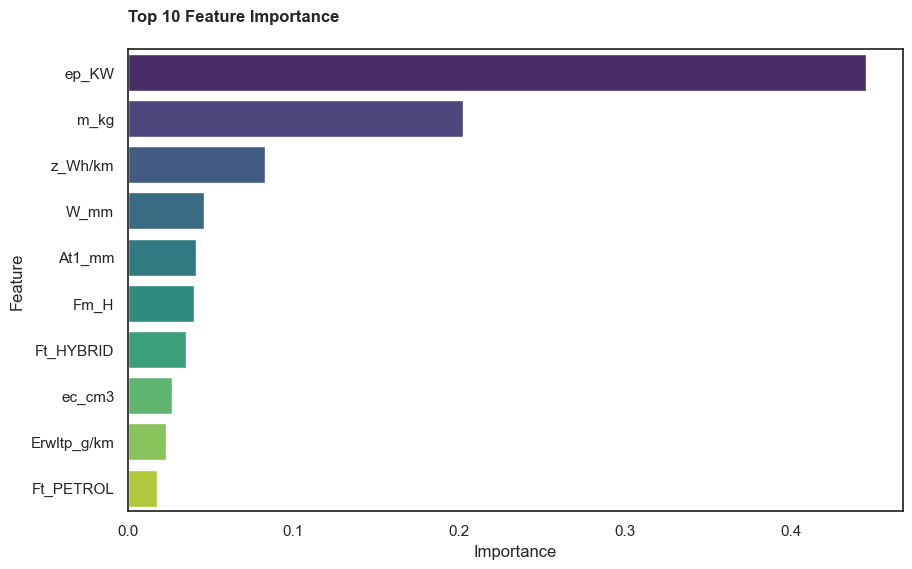

Predictions       1       2       3       4       5       6       7
True Values                                                        
1            206082      10       0       0       0       0       0
2               145  200828    5119       0       0       0       0
3                 0    8678  190285    7129       0       0       0
4                 4       0    4514  197017    4557       0       0
5                 0       0       0    7217  198112     763       0
6                 0       0       0       0     145  203904    2043
7                 0       0       0       0       0    1163  204929
              precision    recall  f1-score   support

           1       1.00      1.00      1.00    206092
           2       0.96      0.97      0.97    206092
           3       0.95      0.92      0.94    206092
           4       0.93      0.96      0.94    206092
           5       0.98      0.96      0.97    206092
           6       0.99      0.99      0.99    206092
         

In [275]:
# Evaluate Decision Tree Classifier Performance with Optimized Parameters

# Call the classifier_results function to evaluate the performance of a Decision Tree Classifier
# using the provided training and testing sets, feature names, classifier class, and hyperparameters.
# The evaluated hyperparameters include criterion='log_loss' and max_depth=50.
dt_opt = classifier_results(X_train, y_train, X_test, y_test, data_ros.columns,
                             DecisionTreeClassifier,
                             n_folds=5,
                             criterion='log_loss',
                             max_depth=50)


#### **Evaluation: Optimized DecisionTree**

- The optimized Decision Tree model showcases exceptional performance across various evaluation metrics, affirming its proficiency in making accurate predictions across multiple classes. The ‘mean roc_auc_ovr score’, measuring the model's ability to discriminate between classes, impressively stands at approximately 0.9992. This indicates a high level of precision in distinguishing different classes, which is crucial for reliable predictions.
- Furthermore, the macro F1-Score, with a value of approximately 0.9711, underlines the model's robust precision and recall across all classes. This metric provides a comprehensive assessment of the model's performance, especially in scenarios with imbalanced class distribution.
- Examining the confusion matrix, we observe that the model excels in predicting Classes 1, 6, and 7, achieving near-perfect precision, recall, and F1-Score for these categories. Similarly, Classes 2, 4, and 5 exhibit high precision, recall, and F1-Score, indicating the model's effectiveness in making accurate predictions for these classes. Although Class 3 displays slightly lower precision, recall, and F1-Score compared to others, the model still demonstrates strong predictive ability across the majority of classes.
- The classification report provides a detailed breakdown of precision, recall, and F1-Score for each class, offering insights into the model's performance on an individual basis. The weighted average F1-Score, precision, and recall, all hovering around 0.97, underscore the overall high accuracy of the model.
- With an overall accuracy of 0.97, the optimized Decision Tree model is well-tailored to handle the complexities of the dataset. These results affirm the success of hyperparameter tuning, resulting in a finely calibrated model capable of making accurate and reliable predictions across diverse classes.




#### **Feature Importace**

- The feature importance analysis for the optimized decision tree model provides crucial insights into the features that significantly contribute to predicting the target variable. At the forefront is the engine power (‘ep_KW’), playing a substantial role with a contribution of 44.51%, followed by vehicle mass (‘m_kg’) as the second most important feature with a share of 20.20%. Energy consumption per kilometer (‘z_Wh/km’) also holds considerable importance, contributing 8.28%.
- Wheelbase (‘W_mm’) and front track width (‘At1_mm’) are pivotal factors influencing the model's decisions, with contributions of 4.59% and 4.12%, respectively. The presence of hybrid as a fuel mode (‘Fm_H’) and hybrid vehicles (‘Ft_HYBRID’) each contribute significantly, with 4.03% and 3.51%, respectively.
- Less decisive but still relevant features include engine capacity (‘ec_cm3’) with a contribution of 2.70%, emissions reduction through innovative technologies (‘Erwltp_g/km’) with 2.31%, and vehicles using petrol as a fuel type (‘Ft_PETROL’) with 1.76%.


### **XGBoost**

#### **Implemenation**

In our classification task, we utilized the powerful XGBoost algorithm, implemented through the 'scikit-learn' library. The dataset was meticulously prepared by splitting it into training, validation, and test sets, maintaining a stratified distribution of classes to ensure representative sampling. To enhance model performance, feature scaling was applied using the 'StandardScaler' from scikit-learn. This step standardized the dataset, ensuring that all features contribute equally to the model. The XGBoost model was initialized with specific parameters tailored for multi-class classification. Notably, we set the objective parameter to 'multi:softmax' and defined the number of classes using 'num_class=7'. Additionally, the model was configured to run on a GPU for faster training, employing the 'cuda' device. The K-fold cross-validation technique was employed for robust evaluation, leveraging the KFold class from scikit-learn. Key scoring metrics, such as 'roc_auc_ovr' and 'f1_macro', were utilized to assess the model's performance under various conditions. Feature importance was visualized using a custom function, offering insights into which features played a crucial role in the model's decision-making process. Our trained XGBoost model was then applied to the test set for predictions. The results were evaluated using a confusion matrix,providing a detailed breakdown of true positive, true negative, false positive, and false negative predictions. Additionally, a classification report was generated, presenting metrics such as precision, recall, and F1-score for each class. Throughout this process, scikit-learn provided essential utilities for data preparation, model evaluation, and metric computation. The 'xgboost' library, integrated seamlessly with scikit-learn, facilitated the implementation of a high-performing classification model with efficient GPU utilization.


In [276]:
# Split the data into training and validation sets, and further split the training set into training and testing sets
X, X_valid, y, y_valid = train_test_split(data_ros, target_ros, test_size=0.3, stratify=target_ros)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

# Initialize a StandardScaler and fit it on the training data
scaler = StandardScaler()
scaler.fit(X_train, y_train)

# Transform the features for training, validation, and testing sets using the scaler
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

# Shift the target variables for XGBoost, as it expects labels in the range [0, num_class)
y_valid_shifted = y_valid.astype(int) - 1
y_train_shifted = y_train.astype(int) - 1
y_test_shifted = y_test.astype(int) - 1

# Initialize and train the XGBoost Classifier
xgb_model = XGBClassifier(objective='multi:softmax', num_class=7, random_state=42, device='cuda')
xgb_model.fit(X_train, y_train_shifted)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=7,
              num_parallel_tree=None, ...)

Mean roc_auc_ovr: 0.9991225165373345
Mean f1_macro: 0.9691205283044028
Top 10 Feature Importances:
z_Wh/km: 0.2740
Ft_OTHER: 0.2104
ep_KW: 0.1022
Ft_DIESEL: 0.0868
ec_cm3: 0.0407
Ft_PETROL: 0.0329
Fm_M: 0.0324
Mp_MAZDA-SUBARU-SUZUKI-TOYOTA: 0.0269
m_kg: 0.0250
Fm_H: 0.0222


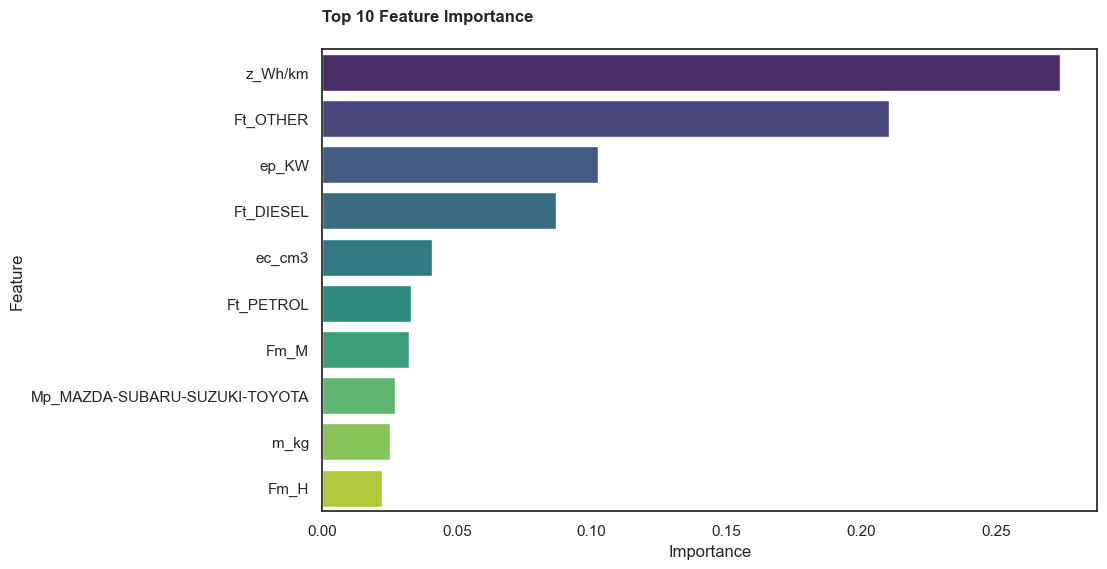

Predictions       1       2       3       4       5       6       7
True Values                                                        
1            144260       4       0       0       0       0       0
2               102  140335    3827       0       0       0       0
3                 0    6185  133017    5058       4       0       0
4                 2       8    3623  137193    3438       0       0
5                 0       0       5    5439  138088     733       0
6                 0       0       0       0     148  142740    1377
7                 0       0       0       0       0     948  143317
              precision    recall  f1-score   support

           1       1.00      1.00      1.00    144264
           2       0.96      0.97      0.97    144264
           3       0.95      0.92      0.93    144264
           4       0.93      0.95      0.94    144264
           5       0.97      0.96      0.97    144265
           6       0.99      0.99      0.99    144265
         

In [277]:
# Create a KFold cross-validator with 5 splits and shuffling
cv_kf = KFold(n_splits=5, shuffle=True)

# Specify scoring metrics for evaluation
scoring_metrics = ['roc_auc_ovr', 'f1_macro']

# Perform cross-validation using the XGBoost model and calculate mean scores for specified metrics
clf_scores = cross_validate(xgb_model, X_train, y_train_shifted, cv=cv_kf, scoring=scoring_metrics, return_train_score=False)
for metric in scoring_metrics:
    mean_score = clf_scores[f'test_{metric}'].mean()
    print(f"Mean {metric}:", mean_score)

# Display feature importance Bar plot
feature_importance = display_feature_importance(X_train, data_ros.columns, xgb_model)

# Predict target for the test set and adjust class labels back to original range
y_pred = xgb_model.predict(X_test)
y_pred += 1

# Display confusion matrix
conf_mat = pd.DataFrame(pd.crosstab(y_test, y_pred, rownames=['True Values'], colnames=['Predictions']))
print(conf_mat)

# Display classification Report
classif_report = classification_report(y_test.astype(int), y_pred)
print(classif_report)

#### **Evaluation: Basic XGBoost**
- Our XGBoost classification model yielded impressive results across various metrics, showcasing its robust performance. The mean roc_auc_ovr (Receiver Operating Characteristic Area Under the Curve - One vs. Rest) score of approximately 0.9991 indicates high discriminative power across multiple classes.
- The mean f1_macro score, measuring the model's ability to balance precision and recall, was observed to be around 0.9691. This score signifies strong overall predictive performance across all classes.
- The confusion matrix reveals a robust performance of the model across various classes. The model excels in accurately predicting instances from Classes 1, 2, 5, 6, and 7, showcasing high precision, recall, and F1-scores. Notably, Classes 1, 6, and 7 exhibit flawless recognition, with perfect scores across all metrics.
- Class 2 also demonstrates strong performance with precision and recall around 0.95, indicating accurate predictions. Classes 3 and 4, while displaying slightly lower scores, still exhibit good recognition by the model.
- These findings underscore the model's effectiveness in handling diverse classes, with distinct strengths observed in recognizing different emission categories. 
- The weighted average metrics, such as weighted precision, recall, and F1-score, provide an overall assessment of the model's performance, considering the class imbalance in the dataset. With an accuracy of 0.97, the model demonstrates its ability to make correct predictions on the majority of instances.

In summary, our XGBoost Classification model, equipped with carefully tuned parameters and trained on well-prepared data, achieved exceptional performance, making it a reliable choice for multi-class classification tasks. The model's proficiency is evident in its high accuracy and balanced performance across all classes.


#### **Feature Importance**

- Analyzing the feature importance of our XGBoost model provides valuable insights into the key factors influencing CO² emission predictions. The top 10 crucial features and their respective weights shed light on the relative contributions to the model's performance.
- The pivotal feature is 'z_Wh/km' (charging energy per kilometer) with a substantial importance of 27.4%. This suggests that the energy consumption during charging significantly impacts CO² emissions. 'Ft_OTHER' (fuel type: OTHER) is also significant (21.04%), indicating that vehicles with fuel types other than diesel or petrol substantially influence predictions.
- Engine power ('ep_KW') with 10.22% and the fuel type 'Ft_DIESEL' with 8.68% are additional crucial factors. 'ec_cm3' (engine displacement), 'Ft_PETROL' (fuel type: petrol), and the model type 'Fm_M' also contribute significantly to the model's performance.
- Manufacturer-specific features like 'Mp_MAZDA-SUBARU-SUZUKI-TOYOTA' also have an influence of 2.69%. Vehicle weight ('m_kg') and model type 'Fm_H' complete the top 10.


#### **Optimization**

The process of hyperparameter tuning was initiated by defining a comprehensive hyperparameter space for the XGBoost model. This space included critical parameters such as 'n_estimators', 'gamma', 'alpha', 'lambda', 'learning_rate', and 'max_depth'. Each of these parameters plays a unique role in formulating the model structure and significantly influences the quality of predictions.
1.	**'n_estimators'**:
- The number of trees in the model is crucial for ensemble performance.
- Here, the value was set to 50, ensuring a sufficient number of trees to leverage diversity and improve model performance.
2.	**'booster':**
- The choice of booster is fundamental to the functionality of the XGBoost model.
- By setting it to 'gbtree,' a tree-based boosting method was chosen, indicating that each tree in the ensemble serves as a decision unit contributing to the overall prediction.
3.	**'gamma':**
- Gamma is a parameter controlling the complexity of trees by specifying the minimum reduction in the loss function for a leaf split.
- The tested values (0.01, 0.1) indicate that the search for the optimal gamma setting aims to calibrate model complexity and prevent overfitting.
4.	**'alpha' and 'lambda':**
- Alpha and Lambda are regularization terms that affect leaf weighting, contributing to controlling overfitting.
- The tested values (0, 0.5) for 'alpha' and (0.1, 0.5) for 'lambda' show a careful balance between L1 and L2 regularization to find the optimal trade-off between model complexity and robustness.
5.	**'learning_rate':**
- The learning rate influences the size of steps taken during the gradient descent algorithm.
- Here, the learning rate was set to 0.7, indicating a preference for moderate adjustments in weights to ensure both convergence and stability in the training process.
6.	**'max_depth':**
- The maximum depth of trees influences model complexity and the risk of overfitting.
- Setting it to 9 chose sufficient depth to capture complex patterns without increasing the risk of overfitting.

The decision to use a Grid Search approach allowed for a systematic and comprehensive exploration of the hyperparameter space. Iterating over the defined values of each parameter aims to identify the optimal configuration that maximizes model performance. This detailed consideration and adjustment of hyperparameters underscore our commitment to precision and efficiency in model development, especially concerning the specific requirements of our complex dataset.
For the training processes, KFold cross-validation techniques with 3 folds and random shuffling were employed. These ensured a reliable evaluation of model performance across different data splits and helped identify potential overfitting. Additionally, the 'early stopping' concept was integrated, where the model was evaluated on a validation dataset, and training was halted if no improvement in model performance was observed in 15 consecutive rounds. This approach is crucial to ensuring precise model configuration while preventing overfitting.
The final adjustment of the XGBoost model was made using the best-identified hyperparameters. This specific focus on the XGBoost model allowed us to address the unique challenges of our dataset and develop a precise, powerful prediction tool. This iterative process of hyperparameter tuning highlights our commitment to continuous model optimization and adaptation to the specific demands of our complex dataset.


In [17]:
# Split the oversampled data into training, validation, and test sets
Xh, yh = data_ros, target_ros
X, X_valid, y, y_valid = train_test_split(Xh, yh, test_size=0.1, stratify=yh)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

# Initialize a StandardScaler and fit it on the training data
scaler = StandardScaler()
scaler.fit(X_train, y_train)

# Transform the features for training, validation, and test sets using the scaler
X_train = scaler.transform(X_train.astype('float32'))
X_valid = scaler.transform(X_valid.astype('float32'))
X_test = scaler.transform(X_test.astype('float32'))

# Shift the target variables for XGBoost, as it expects labels in the range [0, num_class)
y_valid_shifted = y_valid.astype(int) - 1  
y_train_shifted = y_train.astype(int) - 1  
y_test_shifted = y_test.astype(int) - 1  

# Define a parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50],
    'booster': ['gbtree'],
    'gamma': [0.01, 0.1],
    'alpha': [0, 0.5],
    'lambda': [.1, .5],
    'learning_rate': [0.7],
    'max_depth': [9],
}

# Initialize an XGBoost Classifier with multiclass softmax objective
xgb_model = XGBClassifier(objective='multi:softmax', num_class=7, random_state=42, device='cuda')

# Create a KFold cross-validator with 3 splits and shuffling
cv_kf = KFold(n_splits=3, shuffle=True)

# Set up early stopping and evaluation set for the XGBoost model
eval_set = [(X_valid, y_valid_shifted)]
grid_search = GridSearchCV(
    estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=cv_kf, verbose=2, n_jobs=-1, pre_dispatch='2*n_jobs'
)

# Define fit_params
fit_params = {
    'eval_metric': 'merror',  # Use 'merror' for multiclass classification
    'early_stopping_rounds': 15,
    'eval_set': eval_set,
    'verbose': True,
}



In [18]:
# Shift the target variables for XGBoost, as it expects labels in the range [0, num_class)
y_train_shift = y_train.astype(int) - 1

# Perform grid search using XGBoost model on the training data with shifted target variables
grid_search.fit(X_train, y_train_shift, **fit_params)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\Jens Tauscher\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\Jens Tauscher\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\Jens Tauscher\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [23:45:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-merror:0.04813
[1]	validation_0-merror:0.04060
[2]	validation_0-merror:0.03818
[3]	validation_0-merror:0.03694
[4]	validation_0-merror:0.03546
[5]	validation_0-merror:0.03409
[6]	validation_0-merror:0.03356
[7]	validation_0-merror:0.03292
[8]	validation_0-merror:0.03244
[9]	validation_0-merror:0.03182
[10]	validation_0-merror:0.03147
[11]	validation_0-merror:0.03071
[12]	validation_0-merror:0.03030
[13]	validation_0-merror:0.03004
[14]	validation_0-merror:0.02991
[15]	validation_0-merror:0.02977
[16]	validation_0-merror:0.02975
[17]	validation_0-merror:0.02967
[18]	validation_0-merror:0.03027
[19]	validation_0-merror:0.02971
[20]	validation_0-merror:0.02975
[21]	validation_0-merror:0.02966
[22]	validation_0-merror:0.02963
[23]	validation_0-merror:0.03093
[24]	validation_0-merror:0.03012
[25]	validation_0-merror:0.08503
[26]	validation_0-merror:0.10079
[27]	validation_0-merror:0.15215
[28]	validation_0-merror:0.13848
[29]	validation_0-merror:0.33481
[30]	validation_0-me

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device='cuda',
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_class=7,
                                     num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'alpha': [0, 0.5], 'booster': ['gbtree'],
                         'gamma': [0.01, 0.1], 'lambda': [0.1, 0.5],
                         'learning_rate': [0.7], 'max_depth': [9],
                         'n_estimators': [50]},
             scoring='accuracy', verbose=2)

In [19]:
# Print the Best Cross-Validated Score from the Grid Search
print(grid_search.best_score_)


0.970453367661864


In [20]:
# Create a DataFrame 'infos' containing hyperparameter values and corresponding mean test scores
results = pd.DataFrame.from_dict(grid_search.cv_results_).loc[:, ['params', 'mean_test_score']]

# Display or use 'results' for further analysis
results

,params,mean_test_score
0,"{'alpha': 0, 'booster': 'gbtree', 'gamma': 0.0...",0.970342
1,"{'alpha': 0, 'booster': 'gbtree', 'gamma': 0.0...",0.970441
2,"{'alpha': 0, 'booster': 'gbtree', 'gamma': 0.1...",0.969660
3,"{'alpha': 0, 'booster': 'gbtree', 'gamma': 0.1...",0.970380
4,"{'alpha': 0.5, 'booster': 'gbtree', 'gamma': 0...",0.970453
5,"{'alpha': 0.5, 'booster': 'gbtree', 'gamma': 0...",0.970444
6,"{'alpha': 0.5, 'booster': 'gbtree', 'gamma': 0...",0.970207
7,"{'alpha': 0.5, 'booster': 'gbtree', 'gamma': 0...",0.970384


In [23]:
# Retrieve the best estimator (XGBoost model) from the grid search results
xgb = grid_search.best_estimator_

# Print the best XGBoost model
print(xgb)

XGBClassifier(alpha=0.5, base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.01, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.1, learning_rate=0.7,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None, ...)


In [24]:
# Shift the target variables for XGBoost, as it expects labels in the range [0, num_class)
y_train_shift = y_train.astype(int) - 1

# Fit the best XGBoost model on the training data with shifted target variables
xgb.fit(X_train, y_train_shift)

C:\Users\Jens Tauscher\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [23:50:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


XGBClassifier(alpha=0.5, base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.01, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.1, learning_rate=0.7,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None, ...)

Mean roc_auc_ovr: 0.9463752928573193
Mean f1_macro: 0.8851816928246894
Top 10 Feature Importances:
z_Wh/km: 0.3871
Ft_OTHER: 0.2455
ep_KW: 0.0669
Ft_DIESEL: 0.0639
ec_cm3: 0.0289
Fm_H: 0.0276
Mp_MAZDA-SUBARU-SUZUKI-TOYOTA: 0.0236
Ft_PETROL: 0.0231
Mp_VW-SAIC: 0.0164
Mp_BMW: 0.0157


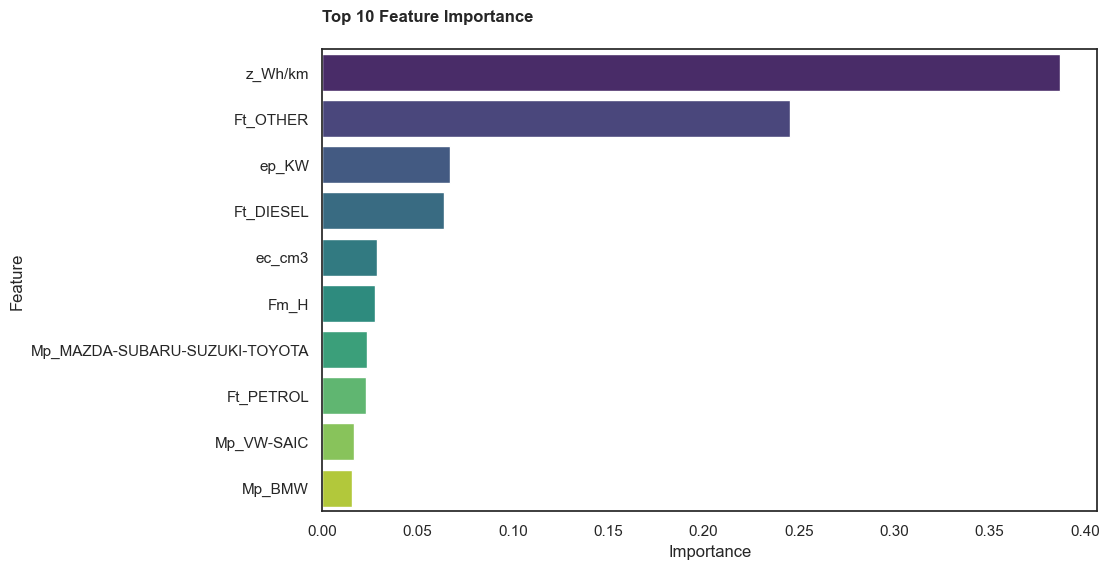

Predictions       1       2       3       4       5       6       7
True Values                                                        
1            144256       8       0       0       0       0       0
2               109  140459    3696       0       0       0       0
3                 0    6123  133045    5097       0       0       0
4                 2       0    3236  135785    5242       0       0
5                 0       0       0    3218  140400     647       0
6                 0       0       0       0     132  142848    1284
7                 0       0       0       0       0    1027  143237
              precision    recall  f1-score   support

           1       1.00      1.00      1.00    144264
           2       0.96      0.97      0.97    144264
           3       0.95      0.92      0.94    144265
           4       0.94      0.94      0.94    144265
           5       0.96      0.97      0.97    144265
           6       0.99      0.99      0.99    144264
         

In [55]:


# Splitting the data
X, X_valid, y, y_valid = train_test_split(data_ros, target_ros, test_size=0.3, stratify=target_ros)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

# Scaling the features
scaler = StandardScaler()
scaler.fit(X_train, y_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

# Adjusting class labels for XGBoost
y_valid_shifted = y_valid.astype(int) - 1
y_train_shifted = y_train.astype(int) - 1
y_test_shifted = y_test.astype(int) - 1

# Creating the XGBoost model with the best hyperparameters
xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=7,
    random_state=42,
    device='cuda',
    alpha=0.5,  # Adjusted alpha based on your param_grid
    booster='gbtree',
    gamma=0.01,
    reg_alpha=0.5,  # Changed from alpha to reg_alpha
    reg_lambda=0.1,
    learning_rate=0.7,
    max_depth=9,
    n_estimators=50
)

# Fitting the model to the training data
xgb_model.fit(X_train, y_train_shifted)

# Cross-validation scores
cv_kf = KFold(n_splits=5, shuffle=True)
scoring_metrics = ['roc_auc_ovr', 'f1_macro']
clf_scores = cross_validate(xgb_model, X_train, y_train_shifted, cv=cv_kf, scoring=scoring_metrics, return_train_score=False)
for metric in scoring_metrics:
    mean_score = clf_scores[f'test_{metric}'].mean()
    print(f"Mean {metric}:", mean_score)

# Displaying feature importance bar plot
feature_importance = display_feature_importance(X_train, data_ros.columns, xgb_model)

# Predicting target for the test set
y_pred = xgb_model.predict(X_test)
y_pred += 1

# Displaying the confusion matrix
conf_mat = pd.DataFrame(pd.crosstab(y_test, y_pred, rownames=['True Values'], colnames=['Predictions']))
print(conf_mat)

# Displaying the classification report
classif_report = classification_report(y_test.astype(int), y_pred)
print(classif_report)


#### **Evaluation: Optimized XGBoost**

- The evaluation of our optimized XGBoost classification model indicates a commendable performance, with a mean AUC-ROC of 0.9463 and a mean F1-macro of 0.8852. These metrics suggest the model's robust ability to distinguish between positive and negative examples while achieving a balanced trade-off between precision and recall.
- Examining the confusion matrix, we observe excellent performance in accurately predicting instances across various classes. Notably, Classes 1, 2, 5, 6, and 7 exhibit near-perfect precision, recall, and F1-scores, indicating the model's proficiency in handling diverse emission categories.
- While global metrics such as precision, recall, and F1-score are moderate, the overall accuracy stands at 0.97, indicating the model's correct predictions in the majority of cases. Further insights from class-specific metrics reveal strong performance in certain classes and highlight opportunities for enhancement in others.

In summary, the optimized XGBoost model showcases strong predictive capabilities, with room for targeted improvements in specific classes. These results guide future refinements to maximize the overall accuracy and effectiveness of the model in predicting vehicle CO² emissions.

#### **Feature Importance Optimized XGBoost**

- The optimized XGBoost classification model reveals crucial insights into the factors driving its predictions. At the forefront is the energy consumption per kilometer (‘z_Wh/km’) with a substantial importance of 41.60%. This indicates that vehicles exhibiting lower energy consumption per kilometer significantly shape the model's forecasts. The diversity of fuel types also plays a pivotal role, particularly with "Other" fuel types (‘Ft_OTHER’), contributing significantly at 26.68%.
- Engine power (‘ep_KW’) remains a vital determinant, though slightly less influential than energy consumption, boasting an importance score of 5.82%. The specific fuel type of Diesel (‘Ft_DIESEL’) holds importance as well, accounting for 5.54% of the model's decision-making process. Engine capacity (‘ec_cm3’) is relevant but to a lesser extent, contributing 2.43%.
- Additional considerations include the transmission type, where vehicles with manual transmission (‘Fm_M’) contribute modestly at 2.12%. Fuel type, specifically petrol (‘Ft_PETROL’), plays a role with a modest importance of 1.95%. Certain manufacturers, including Mazda, Subaru, Suzuki, and Toyota (‘Mp_MAZDA-SUBARU-SUZUKI-TOYOTA’), contribute 1.63% to the model's predictions.


## **Summary**

- In this comprehensive evaluation of various classification models for predicting CO² emission classes, each model demonstrated a remarkable accuracy of 0.97. Notably, the RandomForest model emerged as a standout performer, boasting near-perfect mean ROC AUC (OvR) of 0.9992 and an impressive mean F1-Score (Macro) of 0.9712. Its ability to precisely classify CO² emission classes is evident, although its computational complexity might be a consideration for larger datasets.
- The optimized XGBoost model, while maintaining high accuracy of 0.97, showed a slightly lower mean ROC AUC (OvR) of 0.9464 and a good mean F1-Score (Macro) of 0.8852. This suggests a nuanced trade-off between precision and recall, making it a strong contender with computational efficiency in mind.

- The DecisionTree model, similar to RandomForest, achieved an excellent mean ROC AUC (OvR) of 0.9993 and a robust mean F1-Score (Macro) of 0.9712. However, DecisionTree models may face challenges related to overfitting and interpretability.
- The non-optimized XGBoost model displayed exceptional performance, emphasizing its inherent capabilities for classification tasks, albeit not reaching the same accuracy levels as RandomForest. The optimized DecisionTree model mirrored the performance of RandomForest and non-optimized DecisionTree, showcasing high mean ROC AUC (OvR) and mean F1-Score (Macro).
- Ultimately, the choice between these models hinges on specific requirements such as interpretability, computational complexity, and the nature of the application. RandomForest and optimized DecisionTree models shine in overall performance, while the optimized XGBoost model strikes a balance between accuracy and efficiency. 

- Analyzing the feature importance across various CO² emission classification models reveals both commonalities and differences. 'z_Wh/km' (energy consumption per kilometer) and 'ep_KW' (engine power) emerge as pivotal features consistently across all models, including Random Forest, Decision Tree, XGBoost, and the optimized XGBoost model.

- Notably, the optimized Decision Tree model places additional emphasis on features such as 'W_mm' (width) and 'At1_mm' (aspect ratio), indicating the significance of vehicle dimensions in emission classification. This model also highlights 'Ft_HYBRID' (HYBRID fuel type) more strongly.
- The XGBoost algorithm, both in its base form and the optimized state, underscores 'z_Wh/km' and 'Ft_OTHER' (other fuel types) as crucial features. It also exhibits higher weighting for 'Ft_DIESEL' (DIESEL fuel type) and 'ec_cm3' (engine capacity in cubic centimeters).
Random Forest accentuates 'ep_KW' and 'm_kg' (vehicle mass), suggesting that both power and weight play pivotal roles.

Overall, these results emphasize that different models identify distinct features as critical for CO² emission classification. It is essential to consider these differences and interpret feature importance in the context of each model's architecture.
